Files already downloaded and verified
Files already downloaded and verified


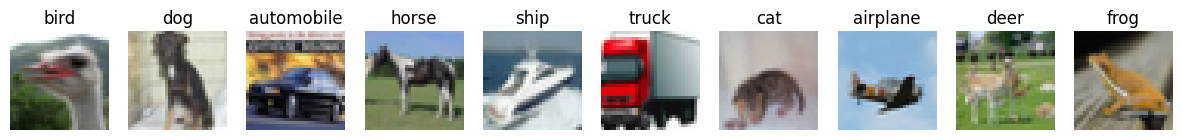

In [ ]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Download and load the CIFAR-10 dataset

mean_data = [0.49139968, 0.48215827 ,0.44653124]
std_data = [0.24703233, 0.24348505, 0.26158768]

transform = transforms.Compose([
            #transforms.Resize(512), # resize, the smaller edge will be matched.
            #transforms.RandomHorizontalFlip(p=0.5),
            #transforms.RandomVerticalFlip(p=0.5),
            #transforms.RandomRotation(90),
            #transforms.RandomResizedCrop(320,scale=(0.3, 1.0)),
            #AddGaussianNoise(0., 1.),
            transforms.ToTensor(), # convert a PIL image or ndarray to tensor.
            transforms.Normalize(mean_data, std_data) # normalize to Imagenet mean and std
            ])

# Inverse normalization transform
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean_data, std_data)],
    std=[1 / s for s in std_data]
)


train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = train_dataset.classes

train_size = 40000
val_size = 10000
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Display one image per class
images_per_class = {}

for img, label in train_dataset:
    if label not in images_per_class:
        images_per_class[label] = img
        if len(images_per_class) == len(classes):
            break

# Plot one image per class
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
for i, (label, img) in enumerate(images_per_class.items()):
    axs[i].imshow(np.transpose(inv_normalize(img).numpy(), (1, 2, 0)))
    axs[i].set_title(classes[label])
    axs[i].axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


In [ ]:
class BaselineModel(nn.Module):
  def __init__(self):
    super(BaselineModel, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc = nn.Linear(32 * 14 *14, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc(x)

    return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    return running_loss / len(train_loader), 100. * correct / total

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return running_loss / len(test_loader), 100. * correct / total


epochs = 30
history = np.zeros((epochs, 4))
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss, train_acc = train_model(baseline_model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_model(baseline_model, val_loader, criterion)
    history[epoch] = [train_loss, val_loss, train_acc, val_acc]
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(baseline_model.state_dict(), "best_baseline_model.pth")

Epoch 1/30, Train Loss: 1.6123, Train Acc: 43.50%, Val Loss: 1.3801, Val Acc: 51.56%
Epoch 2/30, Train Loss: 1.3104, Train Acc: 54.42%, Val Loss: 1.2754, Val Acc: 54.50%
Epoch 3/30, Train Loss: 1.1964, Train Acc: 58.60%, Val Loss: 1.1929, Val Acc: 58.14%
Epoch 4/30, Train Loss: 1.1224, Train Acc: 61.45%, Val Loss: 1.1414, Val Acc: 59.64%
Epoch 5/30, Train Loss: 1.0658, Train Acc: 63.29%, Val Loss: 1.1061, Val Acc: 61.56%
Epoch 6/30, Train Loss: 1.0217, Train Acc: 64.97%, Val Loss: 1.0743, Val Acc: 62.52%
Epoch 7/30, Train Loss: 0.9862, Train Acc: 66.08%, Val Loss: 1.0665, Val Acc: 62.64%
Epoch 8/30, Train Loss: 0.9566, Train Acc: 67.24%, Val Loss: 1.0571, Val Acc: 63.60%
Epoch 9/30, Train Loss: 0.9364, Train Acc: 67.96%, Val Loss: 1.0686, Val Acc: 62.44%
Epoch 10/30, Train Loss: 0.9090, Train Acc: 69.05%, Val Loss: 1.0317, Val Acc: 64.94%
Epoch 11/30, Train Loss: 0.8857, Train Acc: 69.72%, Val Loss: 1.0383, Val Acc: 63.91%
Epoch 12/30, Train Loss: 0.8727, Train Acc: 70.09%, Val Loss: 1

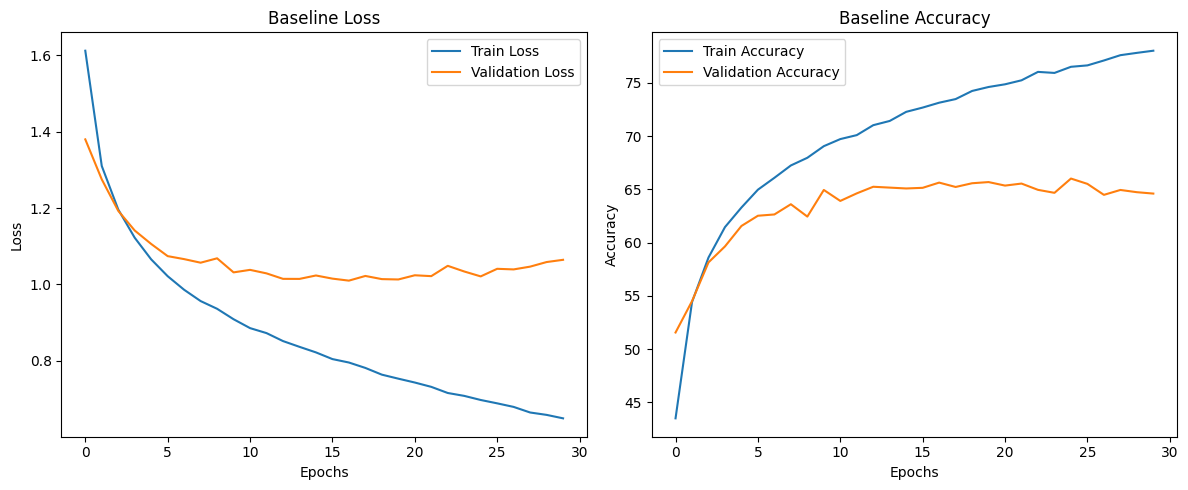

In [ ]:
# Plot training and validation metrics

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history[:, 0], label="Train Loss")
    plt.plot(history[:, 1], label="Validation Loss")
    plt.title(model_name + " Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history[:, 2], label="Train Accuracy")
    plt.plot(history[:, 3], label="Validation Accuracy")
    plt.title(model_name + " Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_history(history, "Baseline")

In [ ]:
class Model2(nn.Module):
  def __init__(self):
    super(Model2, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten()
    )

    self.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
      x = self.conv(x)
      x = self.fc(x)

      return x

model2 = Model2().to(device)
optimizer = optim.SGD(model2.parameters(), lr=1e-3, momentum=0.9)

Epoch 1/30, Train Loss: 2.2997, Train Acc: 10.60%, Val Loss: 2.2927, Val Acc: 12.38%
Epoch 2/30, Train Loss: 2.2215, Train Acc: 17.23%, Val Loss: 2.0794, Val Acc: 22.75%
Epoch 3/30, Train Loss: 1.9324, Train Acc: 29.52%, Val Loss: 1.7812, Val Acc: 35.33%
Epoch 4/30, Train Loss: 1.6984, Train Acc: 37.70%, Val Loss: 1.6219, Val Acc: 39.80%
Epoch 5/30, Train Loss: 1.5921, Train Acc: 41.74%, Val Loss: 1.5534, Val Acc: 42.64%
Epoch 6/30, Train Loss: 1.5147, Train Acc: 44.75%, Val Loss: 1.4844, Val Acc: 45.66%
Epoch 7/30, Train Loss: 1.4481, Train Acc: 47.32%, Val Loss: 1.4086, Val Acc: 49.05%
Epoch 8/30, Train Loss: 1.3912, Train Acc: 49.80%, Val Loss: 1.3468, Val Acc: 50.62%
Epoch 9/30, Train Loss: 1.3384, Train Acc: 51.88%, Val Loss: 1.3108, Val Acc: 51.96%
Epoch 10/30, Train Loss: 1.2885, Train Acc: 53.85%, Val Loss: 1.2529, Val Acc: 54.62%
Epoch 11/30, Train Loss: 1.2421, Train Acc: 55.65%, Val Loss: 1.2270, Val Acc: 54.96%
Epoch 12/30, Train Loss: 1.1975, Train Acc: 57.40%, Val Loss: 1

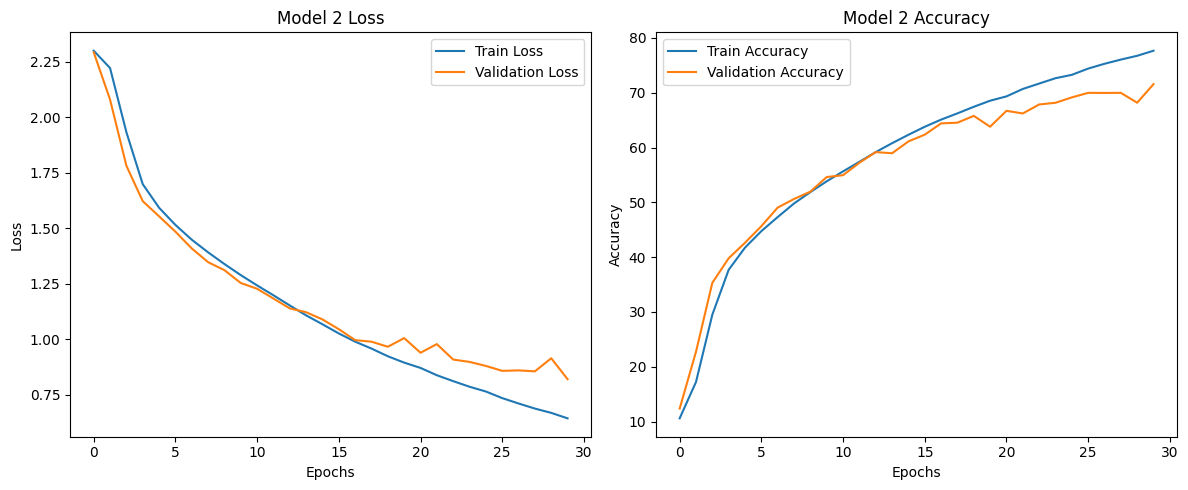

In [ ]:
epochs = 30
history = np.zeros((epochs, 4))
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss, train_acc = train_model(model2, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_model(model2, val_loader, criterion)
    history[epoch] = [train_loss, val_loss, train_acc, val_acc]
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model2.state_dict(), "best_model2.pth")


plot_history(history, "Model 2")

Epoch 1/30, Train Loss: 1.6813, Train Acc: 40.10%, Val Loss: 1.3387, Val Acc: 51.31%
Epoch 2/30, Train Loss: 1.2345, Train Acc: 56.09%, Val Loss: 1.1220, Val Acc: 59.31%
Epoch 3/30, Train Loss: 1.0402, Train Acc: 63.25%, Val Loss: 1.0694, Val Acc: 61.72%
Epoch 4/30, Train Loss: 0.9105, Train Acc: 67.64%, Val Loss: 0.9525, Val Acc: 65.54%
Epoch 5/30, Train Loss: 0.8156, Train Acc: 71.24%, Val Loss: 0.9593, Val Acc: 65.75%
Epoch 6/30, Train Loss: 0.7405, Train Acc: 73.99%, Val Loss: 0.8465, Val Acc: 69.30%
Epoch 7/30, Train Loss: 0.6701, Train Acc: 76.46%, Val Loss: 0.8989, Val Acc: 68.91%
Epoch 8/30, Train Loss: 0.6158, Train Acc: 78.47%, Val Loss: 0.8548, Val Acc: 70.67%
Epoch 9/30, Train Loss: 0.5589, Train Acc: 80.40%, Val Loss: 0.8665, Val Acc: 70.50%
Epoch 10/30, Train Loss: 0.5103, Train Acc: 82.22%, Val Loss: 0.8574, Val Acc: 71.17%
Epoch 11/30, Train Loss: 0.4670, Train Acc: 83.68%, Val Loss: 0.8636, Val Acc: 71.35%
Epoch 12/30, Train Loss: 0.4218, Train Acc: 85.32%, Val Loss: 0

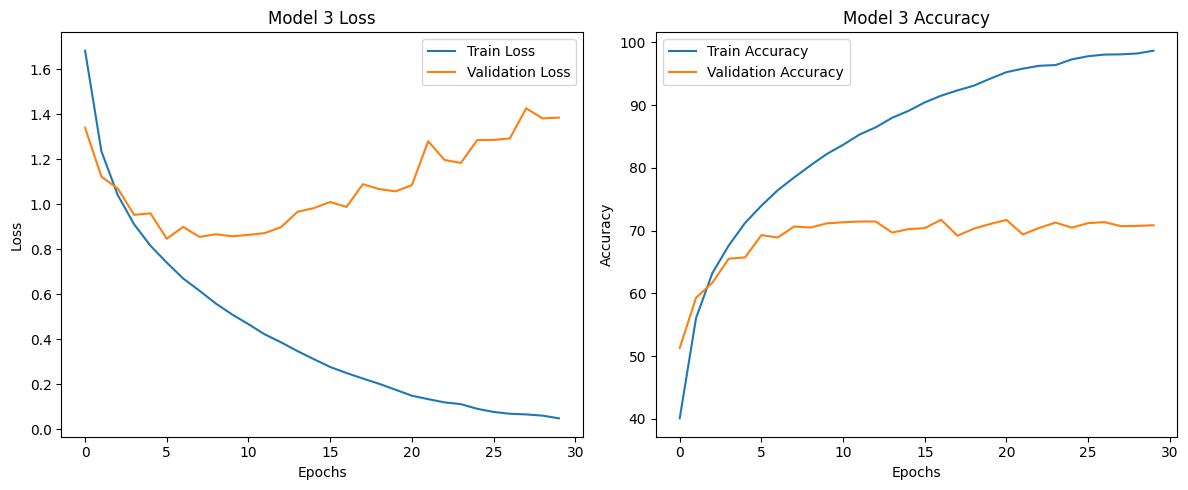

In [ ]:
class Model3(nn.Module):
  def __init__(self):
    super(Model3, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Flatten()
    )

    self.fc = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
      x = self.conv(x)
      x = self.fc(x)

      return x

model3 = Model3().to(device)
optimizer = optim.SGD(model3.parameters(), lr=1e-3, momentum=0.9)

epochs = 30
history = np.zeros((epochs, 4))
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss, train_acc = train_model(model3, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_model(model3, val_loader, criterion)
    history[epoch] = [train_loss, val_loss, train_acc, val_acc]
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model3.state_dict(), "best_model3.pth")


plot_history(history, "Model 3")

Epoch 1/30, Train Loss: 1.8555, Train Acc: 30.84%, Val Loss: 1.5030, Val Acc: 44.07%
Epoch 2/30, Train Loss: 1.4675, Train Acc: 46.02%, Val Loss: 1.3357, Val Acc: 51.16%
Epoch 3/30, Train Loss: 1.2998, Train Acc: 52.93%, Val Loss: 1.1164, Val Acc: 59.68%
Epoch 4/30, Train Loss: 1.1761, Train Acc: 57.72%, Val Loss: 1.0968, Val Acc: 60.04%
Epoch 5/30, Train Loss: 1.0995, Train Acc: 60.74%, Val Loss: 1.0935, Val Acc: 60.25%
Epoch 6/30, Train Loss: 1.0318, Train Acc: 63.26%, Val Loss: 1.0162, Val Acc: 64.19%
Epoch 7/30, Train Loss: 0.9866, Train Acc: 65.00%, Val Loss: 0.9386, Val Acc: 66.46%
Epoch 8/30, Train Loss: 0.9364, Train Acc: 66.74%, Val Loss: 0.8829, Val Acc: 68.37%
Epoch 9/30, Train Loss: 0.8904, Train Acc: 68.49%, Val Loss: 0.9555, Val Acc: 66.61%
Epoch 10/30, Train Loss: 0.8617, Train Acc: 69.64%, Val Loss: 0.8838, Val Acc: 68.40%
Epoch 11/30, Train Loss: 0.8296, Train Acc: 70.72%, Val Loss: 0.7998, Val Acc: 71.72%
Epoch 12/30, Train Loss: 0.7955, Train Acc: 72.12%, Val Loss: 0

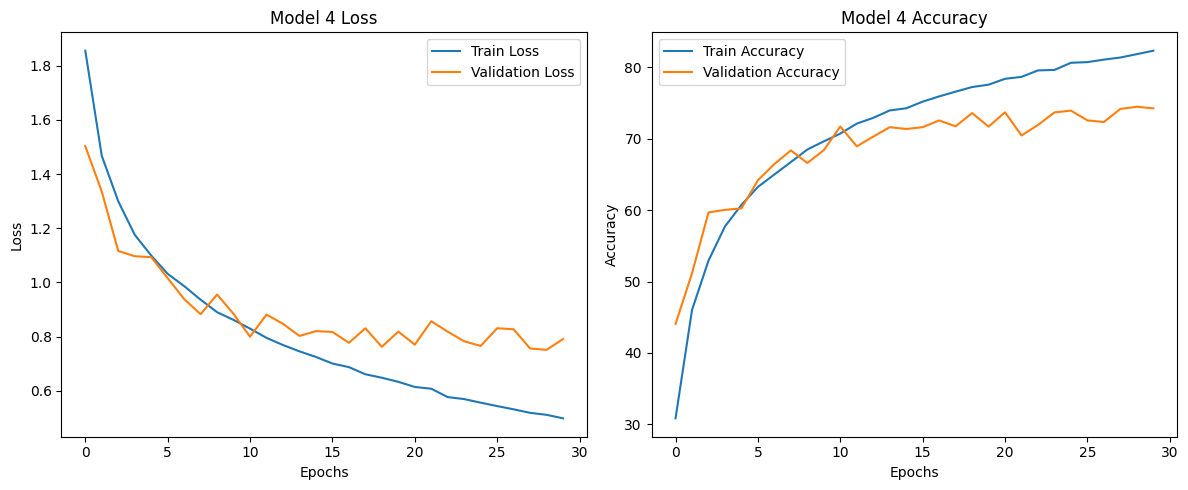

In [ ]:
class Model4(nn.Module):
  def __init__(self):
    super(Model4, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=5, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=5, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Flatten()
    )

    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(256, 10)
    )

  def forward(self, x):
      x = self.conv(x)
      x = self.fc(x)

      return x

model4 = Model4().to(device)
optimizer = optim.SGD(model4.parameters(), lr=1e-3, momentum=0.9)

epochs = 30
history = np.zeros((epochs, 4))
best_val_loss = float('inf')

for epoch in range(epochs):
    train_loss, train_acc = train_model(model4, train_loader, criterion, optimizer)
    val_loss, val_acc = validate_model(model4, val_loader, criterion)
    history[epoch] = [train_loss, val_loss, train_acc, val_acc]
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model4.state_dict(), "best_model4.pth")


plot_history(history, "Model 4")

Baseline test accuracy: 0.6548


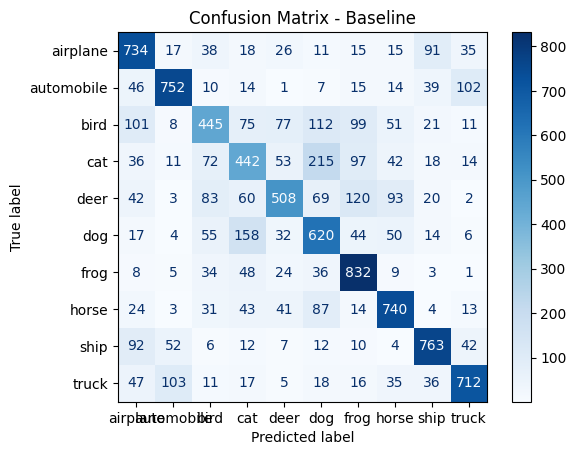

Model 2 test accuracy: 0.7087


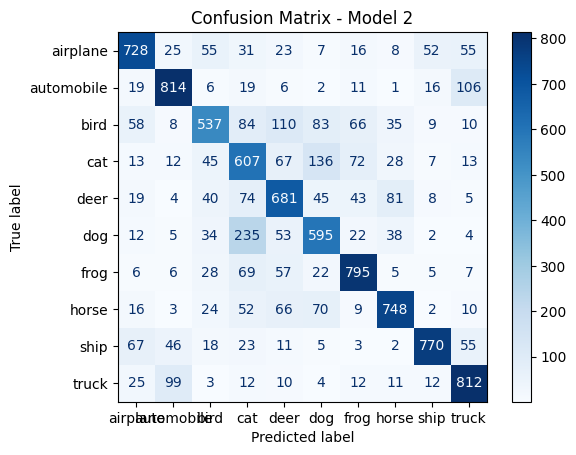

Model 3 test accuracy: 0.6938


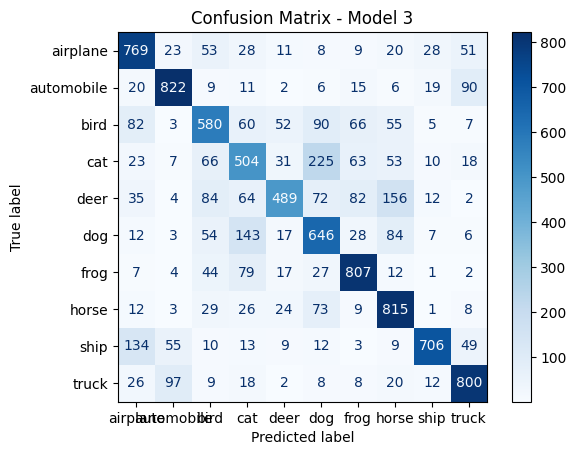

Model 4 test accuracy: 0.7407


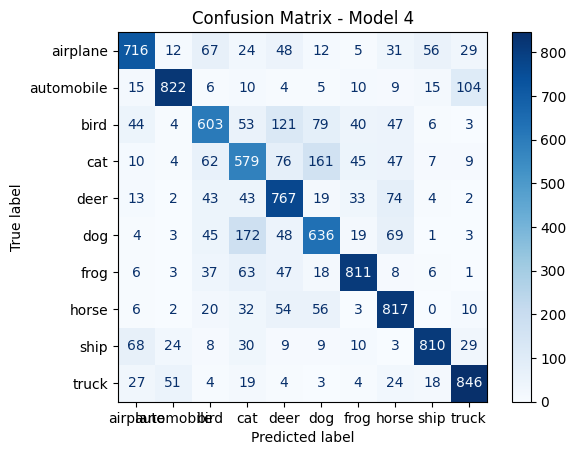

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def test_model(model, model_name, testloader):

    # Initialize lists to store ground truths and predictions
    all_labels = []
    all_preds = []

    # Evaluate the model
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    print(f"{model_name} test accuracy: {np.mean(np.array(all_labels) == np.array(all_preds))}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = testloader.dataset.classes

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - " + model_name)
    plt.show()


model_baseline = BaselineModel()
model_baseline.load_state_dict(torch.load("best_baseline_model.pth", weights_only=True))
model_baseline.eval().to(device)

model2 = Model2()
model2.load_state_dict(torch.load("best_model2.pth", weights_only=True))
model2.eval().to(device)

model3 = Model3()
model3.load_state_dict(torch.load("best_model3.pth", weights_only=True))
model3.eval().to(device)

model4 = Model4()
model4.load_state_dict(torch.load("best_model4.pth", weights_only=True))
model4.eval().to(device)


test_model(model_baseline, "Baseline", test_loader)
test_model(model2, "Model 2", test_loader)
test_model(model3, "Model 3", test_loader)
test_model(model4, "Model 4", test_loader)